In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as STOP_WORDS
from tqdm import tqdm
import math

In [2]:
df = pd.read_csv("data/sampled_train_original.csv")

In [3]:
df

,target,comment_text
0,0.300000,The whole trying to hide the pants thing is an...
1,0.166667,His intimate knowledge of Hitler s life and Na...
2,0.166667,1905 Saskatchewan and Alberta No constitutiona...
3,0.000000,No it is the first
4,0.071429,He comes here to rest his eyes after too many ...
...,...,...
99995,0.600000,I ve been demonized by the Chief Apologist for...
99996,0.833333,these comments are pure cancer
99997,0.300000,Ok so you are being investigated but you are a...
99998,0.471429,Kevka that s the most disgusting comment I ve ...


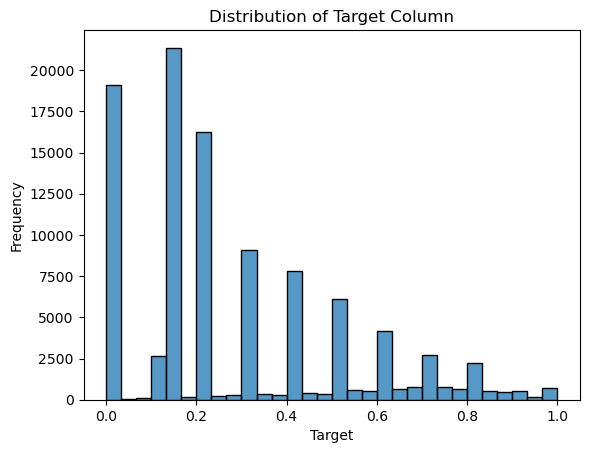

In [6]:
sns.histplot(df['target'], bins=30)
plt.title('Distribution of Target Column')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

In [58]:
# == 0: not toxic at all.              Size: 19012
# > 0 and < 0.2: not very toxic.       Size: 24447
# >= 0.2 and < 0.5: kind of toxic.     Size: 34931
# >= 0.5 toxic or very toxic.          Size: 21610
# The idea of grouping. Intuitively we make a split at toxicity score 0.5, and as we compared the comments between those with
# scores >= 0.5 and scores < 0.5, we can tell the toxicity difference in human sense, which confirms us that this grouping is
# reasonable. We see that the size of this group is 21610, where our data size is 100000, about 4-5 times of this group's size.
# Then we see toxicity score == 0 has size 19012, which is about the same size as our first group, and it also makes sense to
# split the "not toxic at all" comments out. Then We decide to split at toxicity score 0.2, to make sure all our groups have
# similar sizes.

df_0 = df[df['target'] == 0]
df_0_02 = df[(df['target'] > 0) & (df['target'] < 0.2)]
df_02_05 = df[(df['target'] >= 0.2) & (df['target'] < 0.5)]
df_05 = df[df['target'] >= 0.5]

In [60]:
conditions = [
    (df['target'] == 0),
    (df['target'] > 0) & (df['target'] < 0.2),
    (df['target'] >= 0.2) & (df['target'] < 0.5),
    (df['target'] >= 0.5)
]

choices = ['Not Toxic at All', 'Not Very Toxic', 'Kind of Toxic', 'Toxic or Very Toxic']

df['toxicity_level'] = np.select(conditions, choices, default='Undefined')



In [69]:
df = df.dropna()
level = df.toxicity_level.unique()
corpus = [' '.join(df[(df.toxicity_level==candidate)].comment_text.tolist()) for candidate in level]

In [71]:
len(corpus)

4

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

stop_words_list = list(STOP_WORDS)
cv=CountVectorizer(stop_words=stop_words_list, ngram_range=(1, 3))
X = cv.fit_transform(corpus)
X = X.toarray()

In [83]:
bow=pd.DataFrame(X, columns = cv.get_feature_names_out())
bow.index=level

In [84]:
bow

,00,00 00,00 00 friday,00 000,00 000 00,00 000 return,00 01,00 01 dec,00 06,00 06 30,...,zzzzzz doesn old,zzzzzzz,zzzzzzz govt,zzzzzzz govt subsidizing,zzzzzzzzzzzz,zzzzzzzzzzzz blown,zzzzzzzzzzzz blown jays,zzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzz ain,zzzzzzzzzzzzzzzzzz ain shame
Kind of Toxic,68,1,1,1,0,1,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
Not Very Toxic,48,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Not Toxic at All,50,0,0,0,0,0,0,0,1,1,...,0,1,1,1,0,0,0,1,1,1
Toxic or Very Toxic,41,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [89]:
#build an empty dataframe
t_bow_df=pd.DataFrame()

# By candidate, divide the number of times a word is said, 
# by the total number of times they've said all the words that they have said (frequency)
bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1) 

for candidate in tqdm(level):
    feat_s = bow[bow.index != candidate].sum()+1 #sum all the times each word was said excluding the candidate
    feat_s_all = np.sum(bow[bow.index != candidate].sum()) # all the total words that were said, excluding the candidate
    tot = feat_s / feat_s_all #find the frequency of words said among other candidates
    row = bow_transformed.loc[candidate] / tot #divide the candidate's array of frequency of words by all other candidates' frequency
    row = pd.DataFrame(row).T #create a df, and transform
    results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency
    
    t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[candidate])]) #append to df

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:57<00:00, 89.32s/it]


In [90]:
t_bow_df.head()

,00,00 00,00 00 friday,00 000,00 000 00,00 000 return,00 01,00 01 dec,00 06,00 06 30,...,zzzzzz doesn old,zzzzzzz,zzzzzzz govt,zzzzzzz govt subsidizing,zzzzzzzzzzzz,zzzzzzzzzzzz blown,zzzzzzzzzzzz blown jays,zzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzz ain,zzzzzzzzzzzzzzzzzz ain shame
Kind of Toxic,-0.289862,1.730897,1.730897,0.730897,-0.269103,1.730897,-0.269103,-0.269103,-0.269103,-0.269103,...,-0.269103,-0.269103,-0.269103,-0.269103,1.730897,1.730897,1.730897,-0.269103,-0.269103,-0.269103
Not Very Toxic,-0.191953,0.515265,0.515265,-0.069697,0.515265,0.515265,2.515265,2.515265,0.515265,0.515265,...,0.515265,0.515265,0.515265,0.515265,0.515265,0.515265,0.515265,0.515265,0.515265,0.515265
Not Toxic at All,0.640910,1.272266,1.272266,0.687303,1.272266,1.272266,1.272266,1.272266,3.272266,3.272266,...,1.272266,3.272266,3.272266,3.272266,1.272266,1.272266,1.272266,3.272266,3.272266,3.272266
Toxic or Very Toxic,0.069396,1.060782,1.060782,2.060782,3.060782,1.060782,1.060782,1.060782,1.060782,1.060782,...,3.060782,1.060782,1.060782,1.060782,1.060782,1.060782,1.060782,1.060782,1.060782,1.060782


Kind of Toxic:


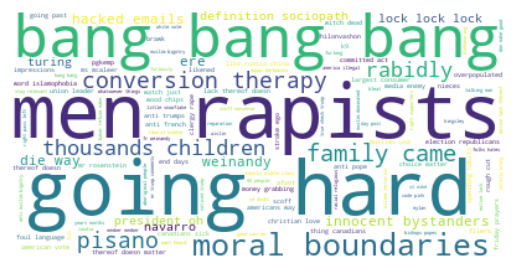

Not Very Toxic:


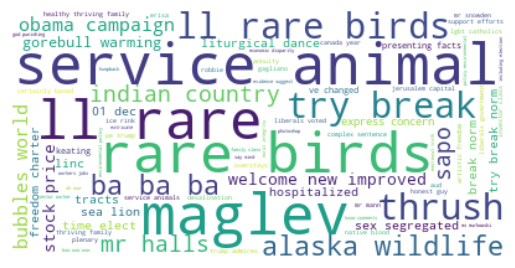

Not Toxic at All:


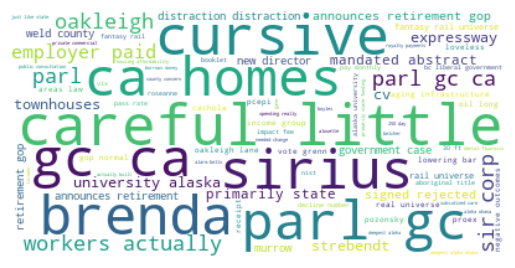

Toxic or Very Toxic:


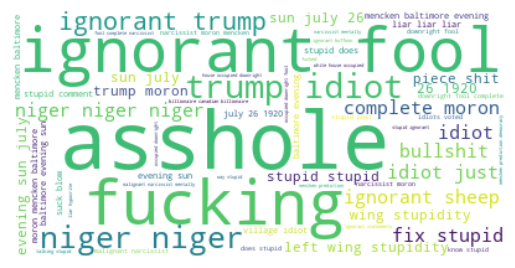

In [93]:
for idx in t_bow_df.index:
    print(idx + ":")
    text=t_bow_df.loc[idx].sort_values(ascending=False)[:4000]
    text2_dict=t_bow_df.loc[idx].sort_values(ascending=False).to_dict()
    wordcloud = WordCloud(min_word_length =3,
                          background_color='white')
    wordcloud.generate_from_frequencies(text2_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [92]:
t_bow_df.index

Index(['Kind of Toxic', 'Not Very Toxic', 'Not Toxic at All',
       'Toxic or Very Toxic'],
      dtype='object')